In [3]:
import sys 
from aima3 import learning
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### 1. Activation Functions
Before we see how neural networks work, we first concentrate on activation functions. We will give some examples.

#### Sigmoid Function
The sigmoid function takes the "S" shape. There are several functions that give a sigmoid function, but typically in neural networks, when we refer to *the* sigmoid function we mean the logistic function, which is:
$$s(z) := \dfrac{1}{1 + e^{-z}}.$$
Let us plot this function for several values of $z$ and see why we have the S-shape.

In [4]:
#Define the sigmoid function
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0 + np.exp(-z))
#generic plot function
def plot_function(f, x):
    plt.plot(x, f(x))
    try:
        title = f.__name__
        plt.title('%s' % title)
        plt.savefig('%s.png' % title)
    except AttributeError as e:
        print(e)
    plt.savefig('out.png')

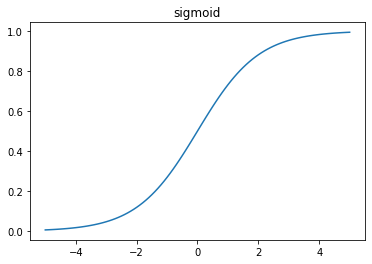

In [5]:
jump = .1
x = np.arange(-5., 5 + jump, jump) #Generate x = -5, -5 + 0.1, -5 + 2 * 0.1, ..., 5 (jump = 0.1 gives 0.1 jumps!)

plot_function(sigmoid, x)

In addition to the S-shape, we always obtain values that are within $[0,1]$. This is because the logistic function always takes values between $0$ and $1$. To see this, observe that as $z \rightarrow \infty$ we have $e^{-z}= 0$ hence $s(z) = 1$ and as $z \rightarrow 0$ we have $e^{-z} = \infty$ hence $s(z) = 0$. 

Thanks to this property, we typically use the sigmoid function to come up with "probabilities" for an instance to belong to either of two classes in a standard classification setting, though there are many extensions possible.

Neural networks use activation functions. We will soon see how to use many of them in an integrated manner to make sophisticated decisions. However, to illustrate the simplest case, we now present a neural network for two-dimensional predictors. 

Assume for simplicity that in a classification problem every instance has $x_1,\ x_2$ values, and our goal is to find the target $y$. We use logistic regression, which returns the probability of an instance having a target, say $+1$ as:
$$ \mathbb{P}[y = 1 | x_1, x_2] = \dfrac{1}{ 1 + \exp( - w_0 - w_1 x_1 -  w_2 x_2)} = s(w_0 + w_1x_2 + w_2x_2).$$

In logistic regression we optimize the parameters $w_0, w_1, w_2$ to make the most meaningful classifications.

This procedure can be summarized by a very simple neural network:
<img src="logistic.png" alt="Drawing" style="width: 400px;"/>

We interpret this network as the following: The input of the network is an instance with variables $x_1$ and $x_2$. There is also an input which is always $+1$ (called the *bias*). The weight of the input $x_1$ is $w_1$, the weight of the input $x_2$ is $w_2$, and the weight of the input $+1$ is $w_0$. The input gets transformed by $w_0 + w_1 x_1 + w_2 x_2$ and enters the activation node. The activation node applies the function $s$ and returns the answer of $s(w_0 + w_1 x_1 + w_2 x_2)$. Our goal is to optimize the weights ($w_0,\ w_1,\ w_2$) of this system so that the final decision is the most meaningful. Note that, the "most meaningul" phrase is vague right now, and soon we will formalize this (the weigths are chosen to minimize a loss over a training set).

We can shift and scale the sigmoid function as the following:

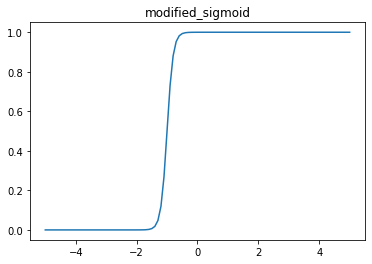

In [6]:
def modified_sigmoid(z):
    """The modified sigmoid function."""
    z = 10*z + 10
    return sigmoid(z)
plot_function(modified_sigmoid, x)

However, in neural networks we will not need to worry about which scaling or shifting to take, as the weights will be optimized in a way that the corresponding 'shape' of the sigmoid function will make the best predictions. In general, for any $w_1, w_2, w_0$ in the above example, if we, for example, take new weights as $2w_1, 2w_2, 2w_0$, then we scaled the input of sigmoid function by $2$. Similarly, if we update $w_0$ as $w_0 + 2$, we shift the input of sigmoid by $2$. Hence, we keep sigmoid function's description as simple as possible, whose input is a scalar $z$. However, in a neural network, the definition of $z$ depends on the weights coming in this activation node and the output of the previous 'layer'. 

#### ReLU (Rectified Linear Unit)
The ReLU function simply keeps the positive part of its argument:
$$r(x) = \max \{0, x\}. $$
Sometimes this function is referred as $\mathrm{ReLU(x)}$.

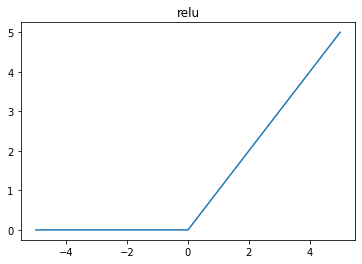

In [7]:
def relu(z):
    """The relu function."""
    return np.maximum(0,z)
plot_function(relu, x)

#### Leaky ReLU
The Leaky ReLU function is simply changing the definition of ReLU slightly for negative inputs:

$$ rl(x) = \begin{cases}
x & \text{ if } x> 0 \\
0.01x & \text{ otherwise.}
\end{cases}$$

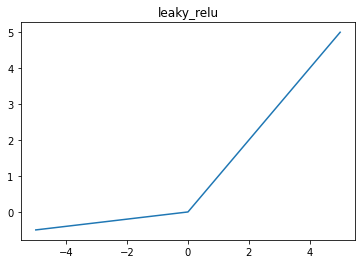

In [6]:
def leaky_relu(z): #using 0.1 instead of 0.01 just to make the plot easier to read
    """The leaky relu function."""
    return 0.1*z + 0.9*np.maximum(0,z)
plot_function(leaky_relu, x)

#### Softplus
Smooth approximation of the ReLU function:
$$ sp(x) =  \log(1 + e^{x})$$

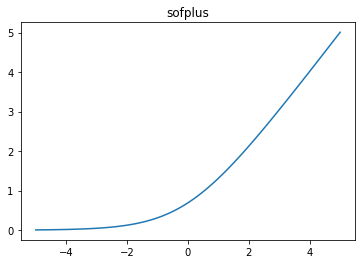

In [7]:
def sofplus(z):
    """The sofplus function."""
    return np.log(1 + np.exp(z))
plot_function(sofplus, x)

**Exercise:** 
The Exponential linear unit (ELU) activation, for some $\alpha > 0$ is:
$$el(X) = \begin{cases} \alpha \cdot( e^x - 1) & \text{ if } x \leq 0 \\  x  & \text{ if } x > 0 \end{cases}.$$
Visualize this activation function for $\alpha = 1$.

There are many more activation functions. However, for now, we move on to how to design a simple neural network.

### 2. Building simple neural networks
Let us use the ReLU function above to make some simple predictions.

Assume that a training point consists of $p$ predictors $\{x_i\}_{i = 1,\ldots, p}$ and a target $y$. Our goal is to 'learn' a function that maps the predictors to the target as accurately as possible **with a fixed network architecture** (as otherwise we can design an arbitrarily deep neural network which can learn everything but it will overfit the training set). Assume this is a regression problem.

For simplicity of notation, let us denote the ReLU activation function as $[y]_+ = \max\{0, y\}$. If $y$ is a vector, then our understanding for $[y]_+$ is that the ReLU function will be applied to each component of $y$.

Now, for a matrix $W \in \mathbb{R}^{q \times p}$, a vector $b \in \mathbb{R}^q$, and a matrix with a single row $H \in \mathbb{R}^{1 \times q}$, let our estimation for $y$ be:
$$\hat{y} = H [W x + b]_+.$$
Here, the rule can be verbally explain as the following: Take the input $x$ and (pre-) multiply it with a matrix $W$ and add a vector $b$ (so we applied an affine transformation on $x$). Take the positive part of the resulting vector. Then, (pre-) multiply this result by $H$ to obtain the final answer. Although this rule might initially look vague, it is shown to be a very strong rule in most settings. See [this SIAM news article](https://sinews.siam.org/Details-Page/the-functions-of-deep-learning) for more details.

In neural networks, our goal is to optimize the 'weights' (or parameters) $W, b, H$ to come up with the best estimation $\hat{y}$ of $y$. The visual description of the above architecture can be summarized as:
<img src="simple_nn.png" alt="Drawing" style="width: 400px;"/>

In this network, we see that there are $p$ inputs (which are corresponding to the elements of some $x \in \mathbb{R}^p$). Moreover, there is an additional input of a fixed constant, $+1$, which is the *bias* term (to see why bias term is useful, see [this discussion](https://stats.stackexchange.com/a/153945/206540])). There is a single hidden layer with $q$ neurons, each denotes as $r_j$ for $j = 1,\ldots,q$. The input of the $j$-th neuron in the hidden layer is: $z_j := w_{j1}x_1 + w_{j2}x_2 + \ldots, w_{jp}x_p + b_j$. Moreover, the output of this neuron is the ReLU activation of its input $r_j = [z_j]_{+}$. Finally, the output layer uses the weights $H = [h_1 \ \cdots \ h_q]$ to come up with the estimation $\hat{y} = h_1 r_1 + \ldots + h_q r_q$.

Finally, note that:
- The fact that there are $q$ neurons in the hidden layer is a modeling decision. This is the fixed architecture. In neural networks, we optimize the weights after fixing an architecture. So, in our optimization problem, we will not consider what value of $q$ to take. Same applies to the selection of the activation function as well as the fact that there is only one hidden layer.
- We discussed that the above network is a visual representation of the estimation $H [W x + b]_+$. This compact representation is obtained by matrix multiplications. To use this representation, we must note that $H$ is a matrix whose $(1,j)$-th value is $h_j$, $W$ is a matrix whose $(j,i)$-th value is $w_{ji}$, and $b$ is a vector whose $j$-th element is $b_j$.

Above, we saw a very simple neural network. We have not discussed how to optimize its weights, neither did we explore options to generalize this network. We will be able to add as many hidden layers as possible to the network, with different activation functions and neuron numbers (depths). Similarly, we will be able to add the bias term to each layer. Moroever, we will also be able to have multi-class classification/regression by having multiple neurons in the output layer rather than just one.

To this end, we now discuss some of the useful properties that we will use in the following. We will see shortly that deep neural networks ('deep' corresponds to increasing the number of layers) can be used to approximate any function, and that it generalizes some of our old friends, including the linear and logistic regressions. 

There are 5 important steps in creating a function $F(x, w)$ that corresponds to the decision of a neural network, where $w$ are weights and $x$ the data:
1. Key operation: **Composition** $F = F_3(F_2(F_1(x, w))))$ (*e.g.*, recall how we multiplied $x$ with a matrix, added a vector, multiplied with another, etc., we composed many functions!).
2. Key algorithm: **Stochastic Gradient Descent** to find the best weights $w$.
3. Key rule: **Chain rule** to compute derivatives that are used in stochastic gradient descent (the 'chain' comes from the composition).
4. Key subroutine: **Backpropagation** to execute the chain rule efficiently.
5. Key nonlinearity: **Rectifier** $\text{ReLU}(y) = r(y) = [y]_+$ ramp function, that we introduced before (will be simply referred as rectifier).

Above, the first element (composition) will be used to add more complexity to the network. In the above example we used a single hidden layer and the composition we took was a linear (multiplying with $H$) - sigmoid (applying $[\cdot]_+$) - affine (applying $Wx + b$ to the input). 

***

**Exercise:**
Write the explicit functional expression describing the following network architecture displayed in the diagram below (from [1]). You can assume that the activation function from layer 2 to layer 3 is of ReLU type. Moreover, assume that there is a bias term connecting to each layer. Count the number of weights in this architecture. 

<img src="demond_fig3.png" alt="Drawing" style="width: 300px;"/>



*** 

#### Reading: 
1. Deep Learning: An Introduction for Applied Mathematicians, Desmond Higham, Arxiv:1801.05894 
2. Approximation by superpositions of a sigmoidal function, Mathematics of Control, Signals, and Systems 7 (1989) 303-314

#### Answer:
    Lets assume inputs are X(2x1)
    
    Output neurons are Y(2x1)
    Wi are weight matrices, b is bias vectors
    
    W2  = layer2-layer1 = (2x2)
    
    W3 = layer3-layer2 = (3x2)
    
    W4 = layer4(output)-layer3 = (2x3)
    
    b2 = bias with layer2(2x1)
    
    b3 = bias with layer3(3x1)
    
    b4 = bias with layer4(2x1)
    
   
   #### Functional expression considering L2-L3 is Relu, all layers have bias terms
    
        Y = W4 * ReLU(W3 * (W2X+b2) + b3) + b4
        
        
   #### Total number of weights + biases
    Weights : 2x2 + 3x2 + 2x3
              = 4 + 6 + 6 + 7
              = 16 + 7
              = 23
                
    

### 3. Using PyTorch for Neural Networks

To compute with Neural Networks, we will be using Python library `torch`: 
```python
from __future__ import print_function
import torch
x = torch.rand(5, 3) #example usage
```
In the course of this section and the next two sections we will explain the library's API in more detail.

In [10]:
from __future__ import print_function
import torch

Using `PyTorch` we're going to rewrite the example above 

In [14]:
import torch.nn as nn 
import torch.nn.functional as func 

# in PyTorch we have to start defining the linear functions of each layer
F_1 = nn.Linear(in_features=2, out_features=2, bias=True) #bias = True adds the bias term for input - layer 1 weights
print('A_2:', F_1.weight, '\n', 'b_2:', F_1.bias) #weights are assigned randomly

A_2: Parameter containing:
tensor([[-0.2203,  0.6899],
        [ 0.2530,  0.4930]], requires_grad=True) 
 b_2: Parameter containing:
tensor([0.2743, 0.3563], requires_grad=True)


From `F_2` above we can define a function in Python using either the `lambda` or the `def` keywords: 

```python 
def F_2(x):
    return F_2.forward(x) # or just F_2(x)
```

In [18]:
x = torch.from_numpy(np.array([1., 2.], dtype=np.float64)).float() #use numpy commands -- example input to Layer 2
L_2 = nn.Linear(in_features=2, out_features=3, bias=True) #define the second step -> 2 - to 3 + the bias term 
F_2 = lambda x: func.relu(L_2.forward(x)) # F_2 applies the ReLU activation on the L_2 evaluation.
F_2(x)

tensor([1.0440, 0.0000, 1.6480], grad_fn=<ReluBackward0>)

We can apply the above steps by simple algebra, so what `torch` applies is not a mystery:

In [20]:
weights = L_2.weight.detach().numpy() #the weights L2 uses are taken
x_vect = x.detach().numpy().reshape(2,1) #we take the input as a numpy array
input_of_L_2 = weights.dot(x_vect) + L_2.bias.detach().numpy().reshape(3,1) #now apply the affine transformation
output_of_L2 = relu(input_of_L_2) #composition with the relu function (activate the input)
output_of_L2 #this is what F_2 returns

array([[1.0439539],
       [0.       ],
       [1.6479619]], dtype=float32)

Finally we apply the last layer:

In [22]:
L_3 = nn.Linear(in_features=3, out_features=2, bias=True)
F_3 = lambda x: L_3.forward(x) #this is just evaluation, here we do not apply ReLU (or this is "identity activation")
F_3(F_2(x))

tensor([0.4319, 0.0668], grad_fn=<AddBackward0>)

We defined all layers. Now, to make prediction, we can simply compose the layers:

In [14]:
F = lambda x: F_3(F_2(F_1(x)))

And finally giving an input to `F` will return an output:

In [15]:
x = torch.from_numpy(np.array([1., 2.], dtype=np.float64)).float()
y = F(x)
y

tensor([-0.0856, -0.4549], grad_fn=<AddBackward0>)

In [16]:
x = torch.from_numpy(np.array([-2, 5], dtype=np.float64)).float()
y = F(x)
y

tensor([-0.0856, -0.4549], grad_fn=<AddBackward0>)

Note that `F` is just a function with fixed weights. The reason is since `torch` automatically assigns initial weights. In the next notebook we will see how to optimize the weigths for a purpose.

#### 4. Visualizing a Network Architecture

In [ ]:
# here's another way of constructing your computational graph by using the library torchviz
# we will discuss computational models again later in this module
from torch.autograd import Variable
from torchviz import make_dot 
model = nn.Sequential()
model.add_module('W1', nn.Linear(2,2)) #add a layer with linear transformation as before
model.add_module('W2', nn.Linear(2,3)) #add another layer similarly
model.add_module('relu', nn.ReLU()) #add a ReLU activation
model.add_module('W3', nn.Linear(3, 2)) #add a final linear layer
x = Variable(torch.randn(1, 2)) #input variable
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

We can change the activation functions and number of layers for different purposes. For example, we can represent logistic regression with the architecture shown in the beginning of this notebook. We can visualise the architecture by using `torchviz`.

In [ ]:
# this is how a simple logistic regression would look like
model = nn.Sequential()
model.add_module('W0', nn.Linear(2, 2))
model.add_module('logit', nn.Sigmoid()) #sigmoid activation
x = Variable(torch.randn(1, 2))
y = model(x)
make_dot(y.max(), params=dict(model.named_parameters()))

The strange name of the operations and variables in the PyTorch computational graph may not make much sense right now, but as we progress in this class we'll be piecing the different parts of the puzzle together. 

#### 5. Demonstration of the Logistic Regression via a Neural Network

In the beginning of this notebook, we discussed that in the two-dimensional feature setting, the probability of an instance to belong the target +1 (assuming there are two targets) is
$$ \mathbb{P}[y = 1 | x_1, x_2] = \dfrac{1}{ 1 + \exp( - w_0 - w_1 x_1 -  w_2 x_2)} = s(w_0 + w_1x_2 + w_2x_2).$$

**Exercise:** 
Find the probability $\mathbb{P}[y = 1 | x_1, x_2]$ where $w_0 = 1, w_1 = 0.3, w_2 = -0.1$ for the input $x = (x_1 = 1, x_2 = -2)$.

### Answer

In [32]:
1/(1 + np.exp(-1 -0.3*(1) + 0.1*(-2)))

0.8175744761936437

**Exercise:**
Model the same with a simple neural network. Report the probability of the same input belonging class +1 when the weights are fixed accordingly.
*(Hint: the weights within two layers are automatically being initialized via `torch`, however, you may change it by ```L_1.weight.data = ...``` and ```L_1.bias.data = ...```)*

In [44]:
x = torch.from_numpy(np.array([1., -2.], dtype=np.float64)).float() 
L_1 = nn.Linear(in_features=2, out_features=1, bias=True) 
L_1.weight.data = torch.tensor([[0.3, -0.1]])
L_1.bias.data = torch.tensor([1.])
F_1 = lambda x: func.sigmoid(L_1.forward(x)) # F_1 applies the Sigmoid activation on the L_1 evaluation.
F_1(x)

tensor([0.8176], grad_fn=<SigmoidBackward0>)

In [46]:
print('Probability:', F_1(x).item())

Probability: 0.8175744414329529
